In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

![Снимок экрана 2025-01-22 в 13.49.44.png](<attachment:Снимок экрана 2025-01-22 в 13.49.44.png>)
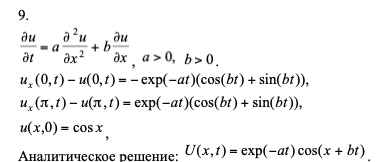

In [85]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(4, 200)  # Вход включает x, t, a, b
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 1)

    def forward(self, x, t, a, b):
        a = a.repeat(x.size(0), 1)  
        b = b.repeat(x.size(0), 1)  

        # Объединяем x, t, a, b
        inputs = torch.cat([x, t, a, b], dim=1)
        x = torch.sin(self.fc1(inputs))
        x = torch.sin(self.fc2(x))
        x = self.fc3(x)
        return x

In [158]:
def compute_u_x(model, x_boundary, t_boundary, a, b):
    x_boundary.requires_grad_(True)
    u_boundary_pred = model(x_boundary, t_boundary, a, b)
    u_x = torch.autograd.grad(u_boundary_pred, x_boundary, grad_outputs=torch.ones_like(u_boundary_pred), create_graph=True)[0]
    return u_x

In [159]:
# Функция потерь на граничных условиях
def boundary_loss(model, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b):
    u_x_0 = compute_u_x(model, x_boundary_0, t_boundary,a,b)
    u_x_pi = compute_u_x(model, x_boundary_pi, t_boundary,a,b)

    u_boundary_pred_0 = model(x_boundary_0, t_boundary, a, b)
    u_boundary_pred_pi = model(x_boundary_pi, t_boundary, a, b)
    u_boundary_0 = model(x_boundary, t_0, a, b)

    # Граничные условия
    boundary_0 = u_x_0 - u_boundary_pred_0 - (-torch.exp(-a * t_boundary) * (torch.cos(b * t_boundary) + torch.sin(b * t_boundary)))
    boundary_pi = u_x_pi - u_boundary_pred_pi - (torch.exp(-a * t_boundary) * (torch.cos(b * t_boundary) + torch.sin(b * t_boundary)))
    boundary_ = u_boundary_0 - torch.cos(x_boundary)

    # Потери на граничных условиях
    return torch.mean(boundary_0**2) + torch.mean(boundary_pi**2) + torch.mean(boundary_**2)


In [160]:
def loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation="heat"):
    # Потери на внутренних точках
    u_pred = model(x_interior, t_interior, a, b)
    u_t = torch.autograd.grad(u_pred, t_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    if equation == "heat":
        physics_loss = u_t - a * u_xx
    elif equation == "wave":
        u_tt = torch.autograd.grad(u_t, t_interior, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
        physics_loss = u_tt - a * u_xx - b * u_t
    else:
        raise ValueError(f"Unknown equation type: {equation}")

    b_loss = boundary_loss(model, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b)
    return torch.mean(physics_loss**2) + b_loss

In [161]:
# Инициализация данных
n_interior = 200
n_boundary = 200

x_interior = torch.tensor(np.linspace(0, np.pi, n_interior).reshape((n_interior, 1)), dtype=torch.float32, requires_grad=True)
t_interior = torch.tensor(np.random.uniform(0, 5, size=(n_interior, 1)), dtype=torch.float32, requires_grad=True)

x_boundary = torch.tensor(np.linspace(0, np.pi, n_boundary).reshape((n_boundary, 1)), dtype=torch.float32, requires_grad=True)
t_boundary = torch.tensor(np.random.uniform(0, 5, size=(n_boundary, 1)), dtype=torch.float32, requires_grad=True)

x_boundary_0 = torch.zeros_like(t_boundary, requires_grad=True)
x_boundary_pi = torch.full_like(t_boundary, np.pi, requires_grad=True)
t_0 = torch.zeros_like(x_boundary, requires_grad=True)

In [90]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [91]:
n_epochs = 10000
loss_history = []
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    equation_type = np.random.choice(["heat", "wave"])
    a_value = np.random.uniform(0.5, 2.0)  
    b_value = np.random.uniform(0.5, 2.0)  

    # Повторяем параметры a и b для всех точек
    a = torch.tensor(a_value, dtype=torch.float32).view(1, 1)  # Повторяем для каждой точки
    b = torch.tensor(b_value, dtype=torch.float32).view(1, 1)  # Повторяем для каждой точки

    loss = loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation=equation_type)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())


100%|██████████| 10000/10000 [01:06<00:00, 149.97it/s]


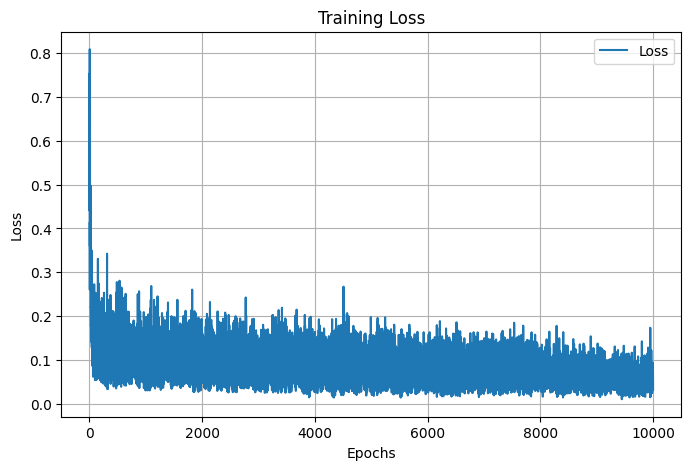

In [92]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

In [100]:
# Тестирование точного решения
def exact_solution(x, t, a, b):
    return np.exp(-a * t) * np.cos(x + b * t)

x_test = torch.tensor(np.linspace(0, np.pi, 100), dtype=torch.float32).view(-1, 1)
t_test = torch.tensor(np.linspace(0, 5, 100), dtype=torch.float32).view(-1, 1)
x_mesh, t_mesh = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="ij")

a_test = torch.tensor(1.0, dtype=torch.float32).view(1, 1)
b_test = torch.tensor(1.0, dtype=torch.float32).view(1, 1)


u_pred = model(x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1), a_test, b_test).detach().numpy().reshape(x_mesh.shape)
u_exact = exact_solution(x_mesh.numpy(), t_mesh.numpy(), a_test.item(), b_test.item())

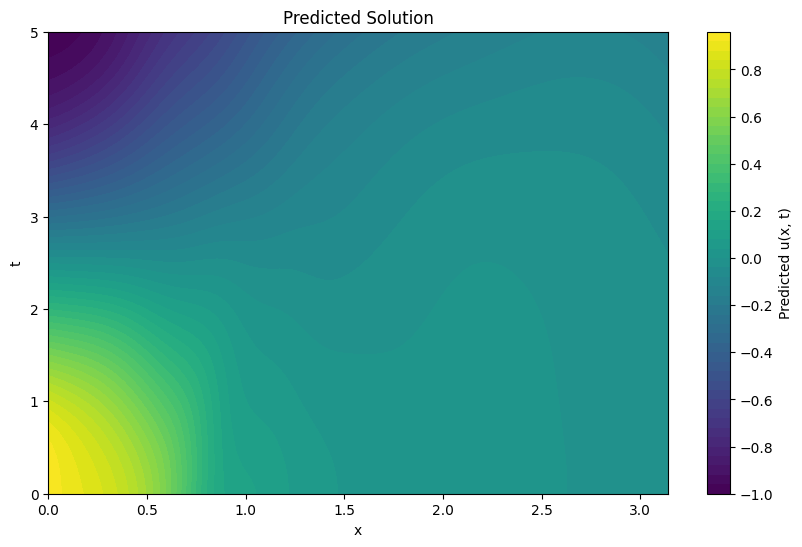

In [101]:
plt.figure(figsize=(10, 6))
plt.contourf(x_test.numpy().squeeze(), t_test.numpy().squeeze(), u_pred, levels=50, cmap="viridis")
plt.colorbar(label="Predicted u(x, t)")
plt.title("Predicted Solution")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

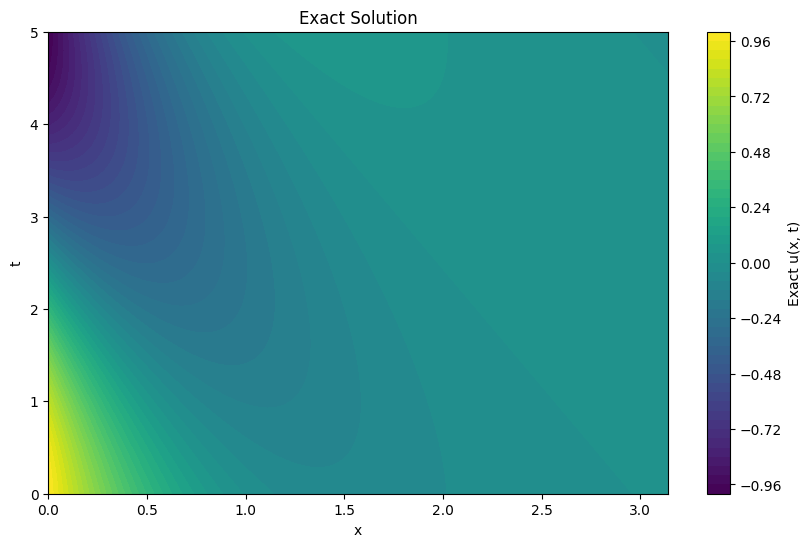

In [102]:
plt.figure(figsize=(10, 6))
plt.contourf(x_test.numpy().squeeze(), t_test.numpy().squeeze(), u_exact, levels=50, cmap="viridis")
plt.colorbar(label="Exact u(x, t)")
plt.title("Exact Solution")
plt.xlabel("x")
plt.ylabel("t")
plt.show()

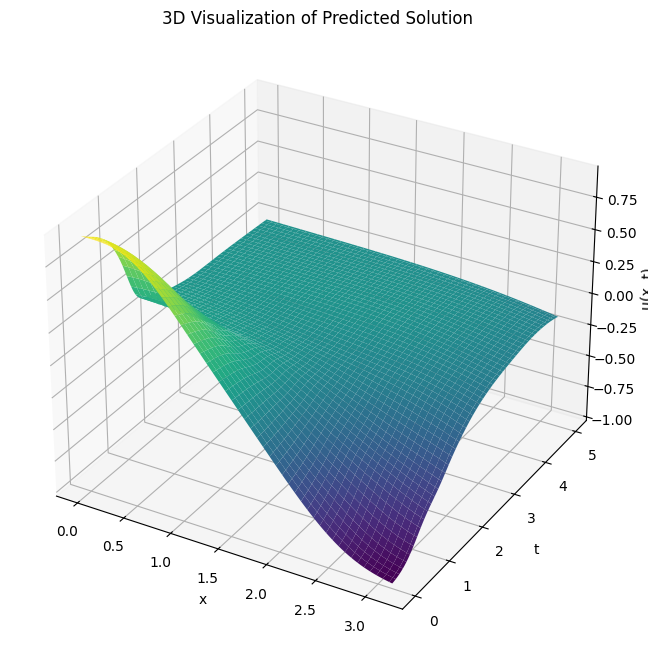

In [104]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh.numpy(), t_mesh.numpy(), u_pred, cmap="viridis")
ax.set_title("3D Visualization of Predicted Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
plt.show()

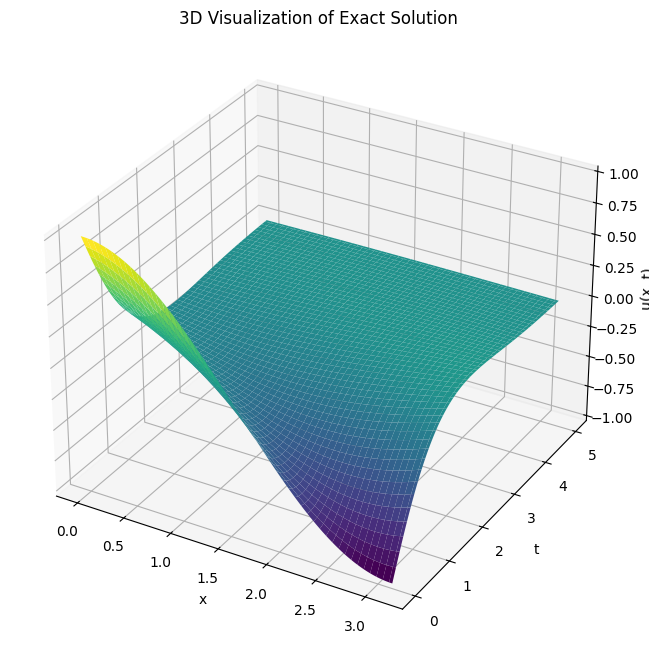

In [105]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh.numpy(), t_mesh.numpy(), u_exact, cmap="viridis")
ax.set_title("3D Visualization of Exact Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
plt.show()

### Посмотрим, что получается с ошибкой при разных сочетаниях a и b

a = 0.0, b = 0.0


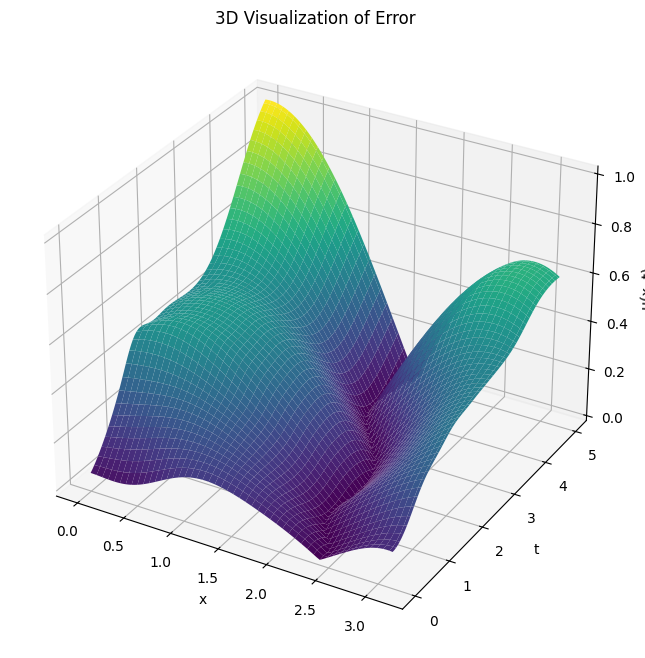

a = 0.0, b = 0.25


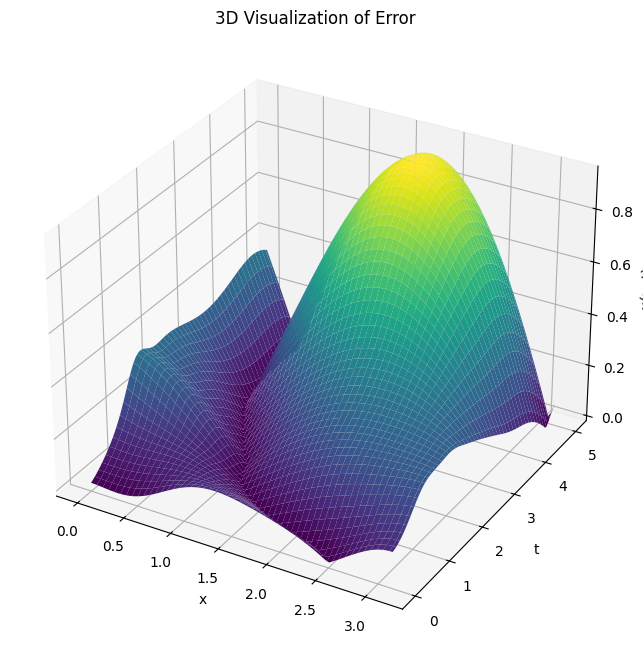

a = 0.0, b = 0.5


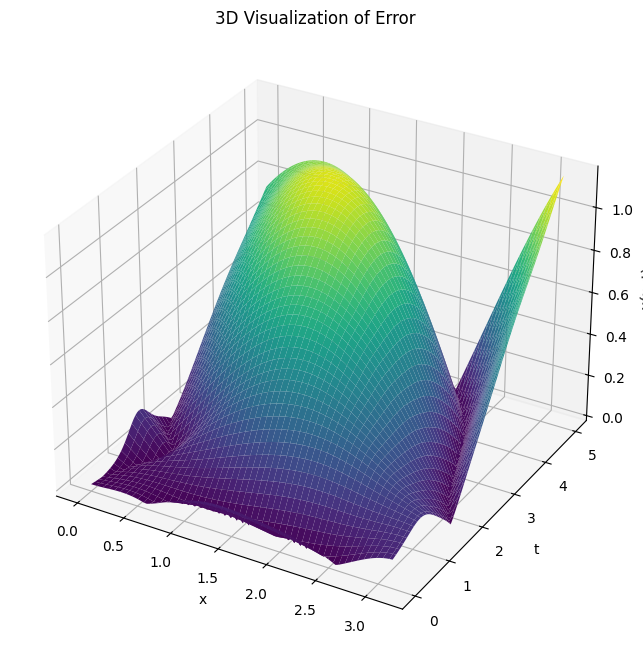

a = 0.0, b = 0.75


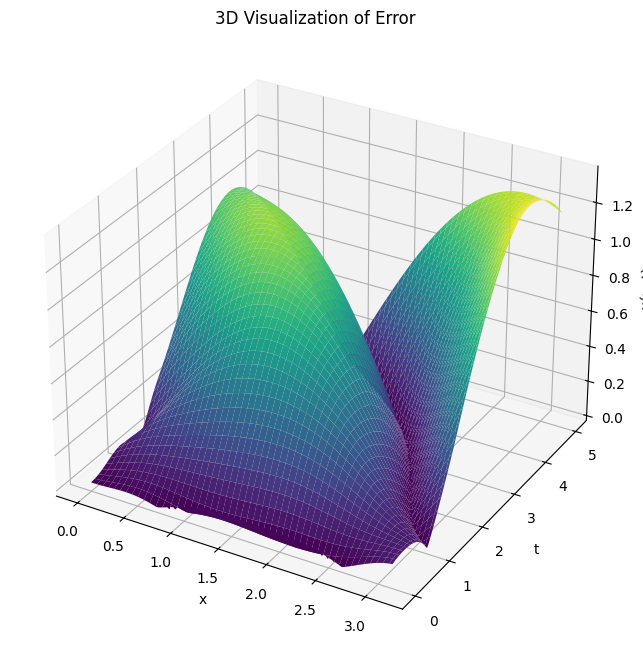

a = 0.0, b = 1.0


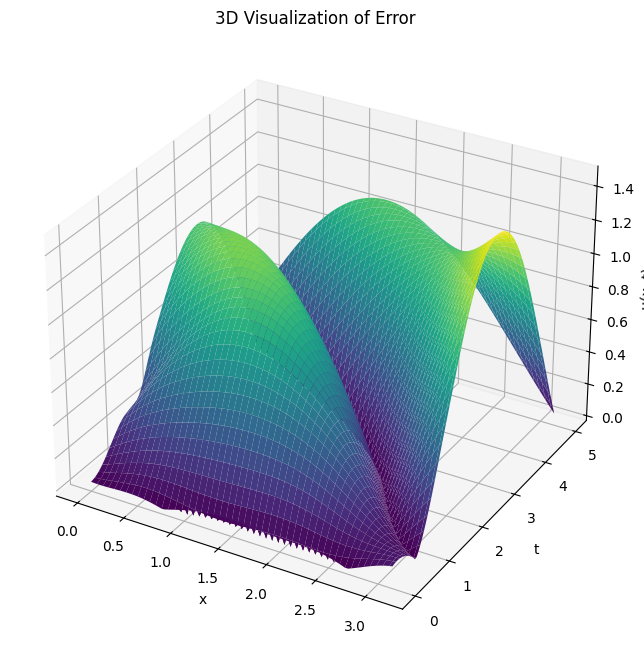

a = 0.25, b = 0.0


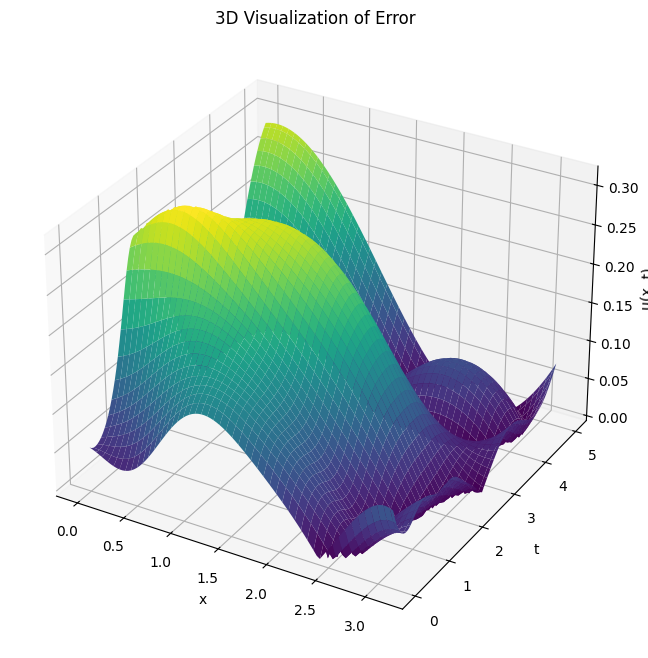

a = 0.25, b = 0.25


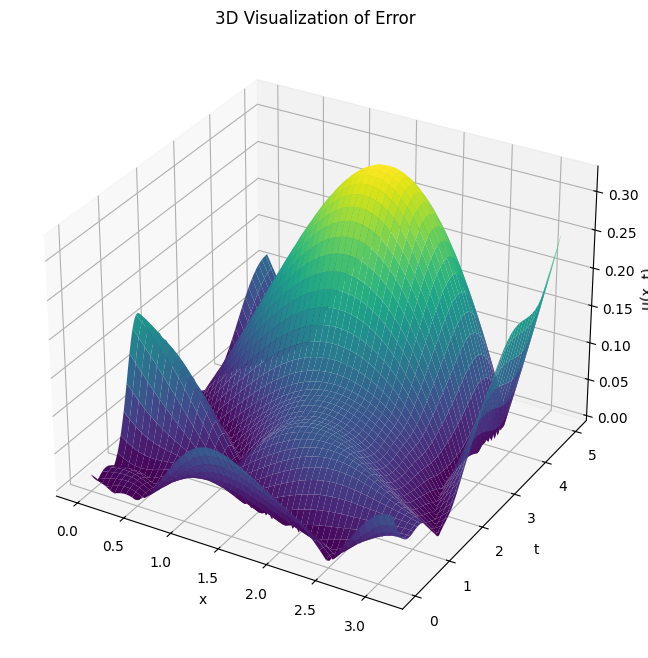

a = 0.25, b = 0.5


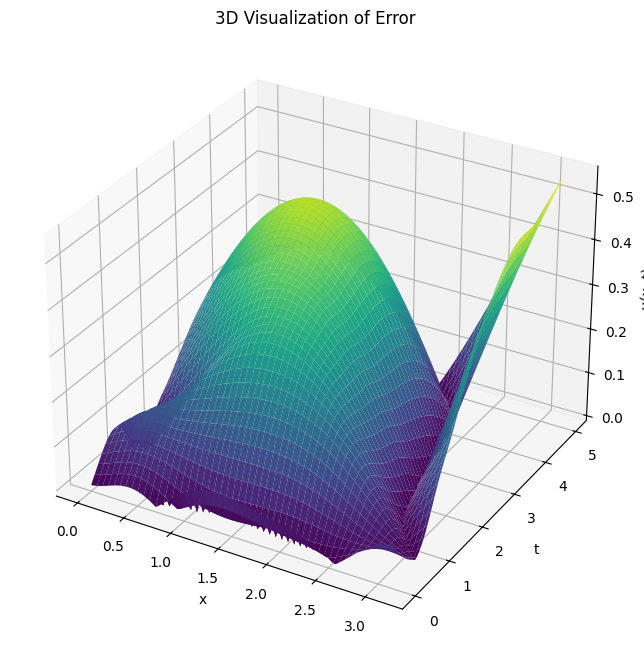

a = 0.25, b = 0.75


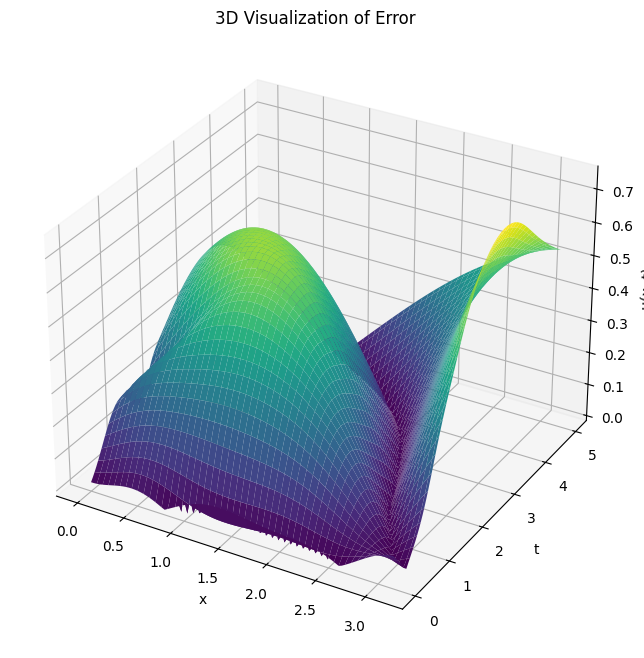

a = 0.25, b = 1.0


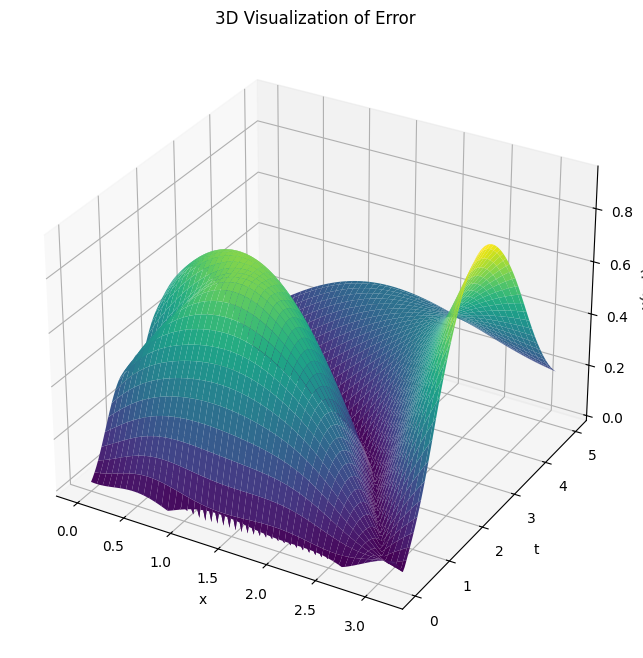

a = 0.5, b = 0.0


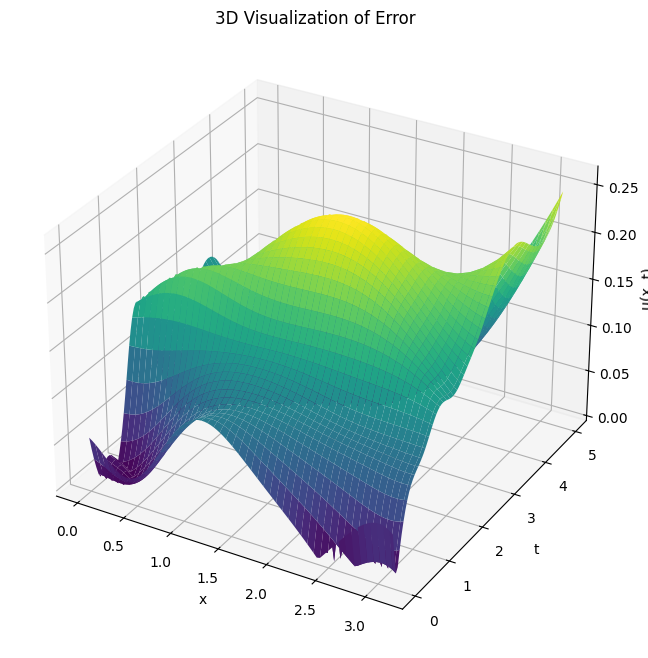

a = 0.5, b = 0.25


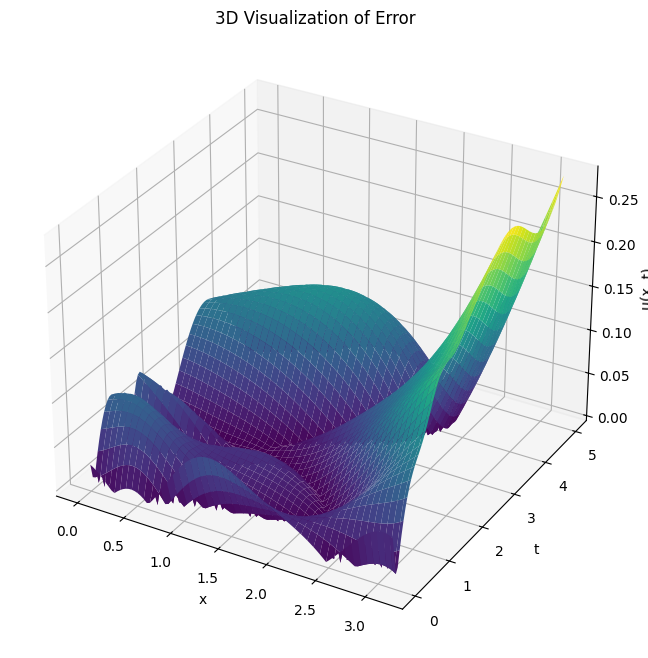

a = 0.5, b = 0.5


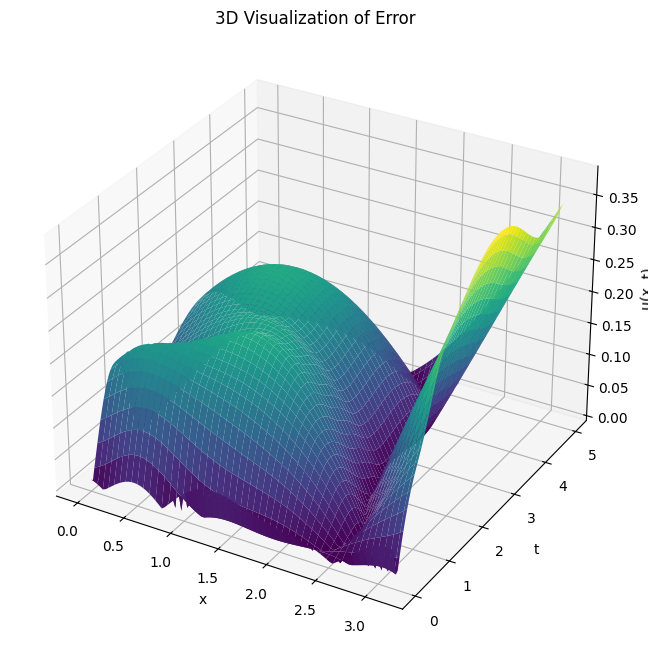

a = 0.5, b = 0.75


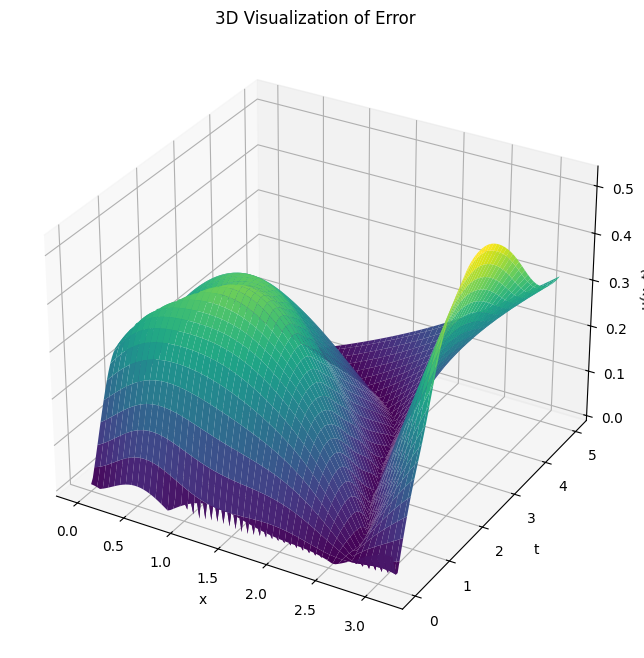

a = 0.5, b = 1.0


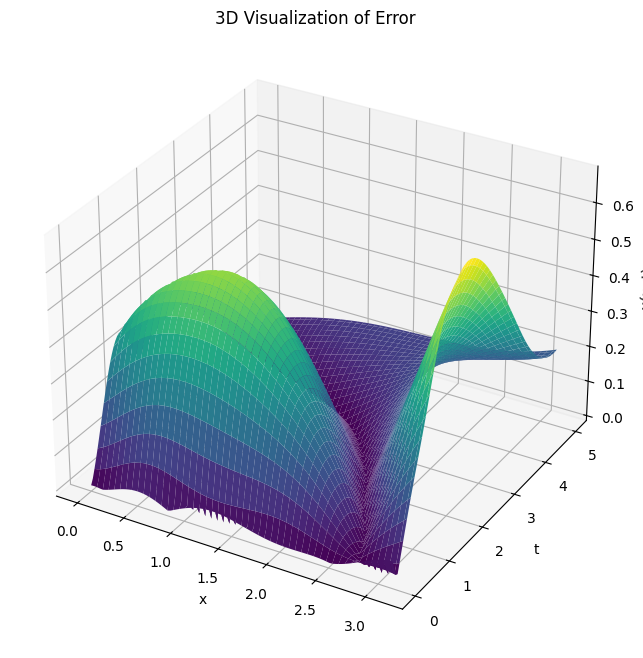

a = 0.75, b = 0.0


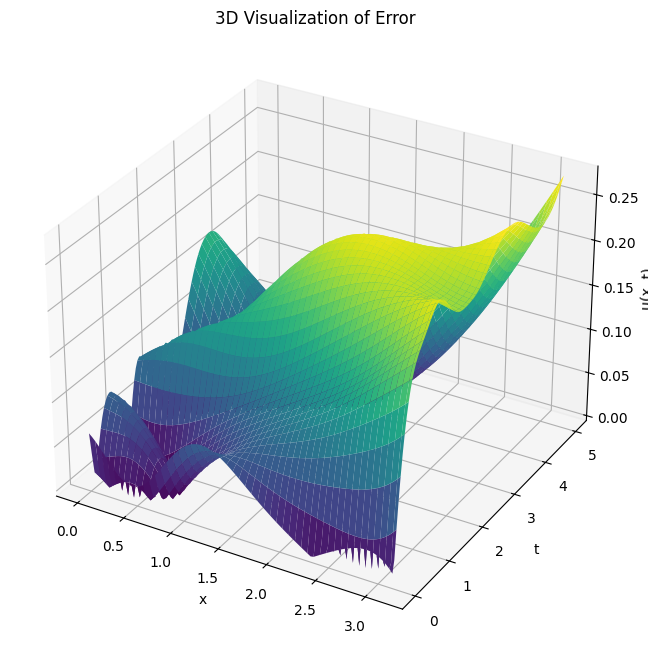

a = 0.75, b = 0.25


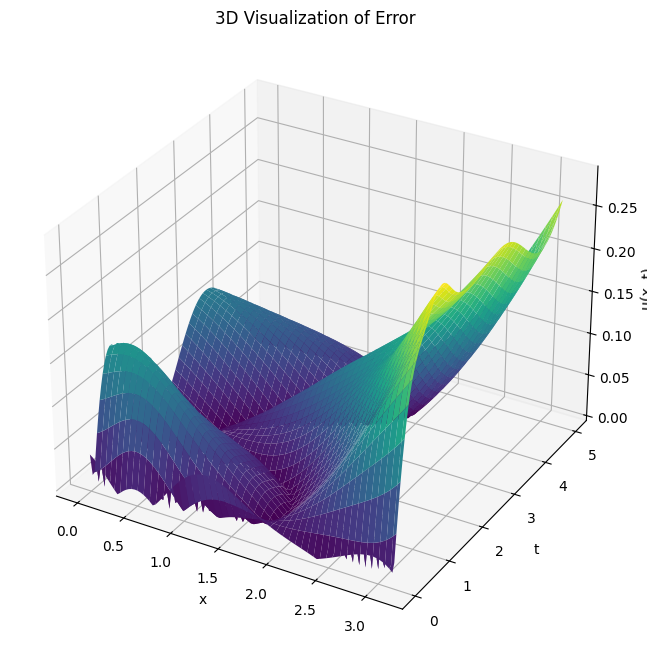

a = 0.75, b = 0.5


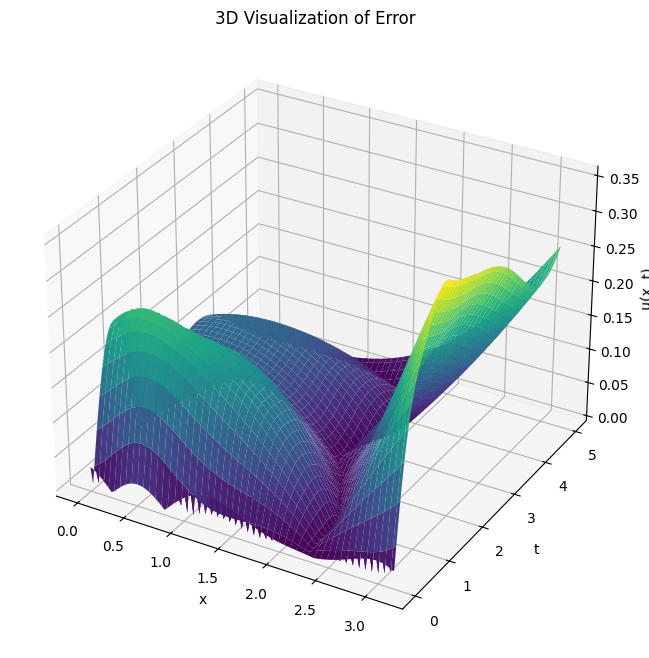

a = 0.75, b = 0.75


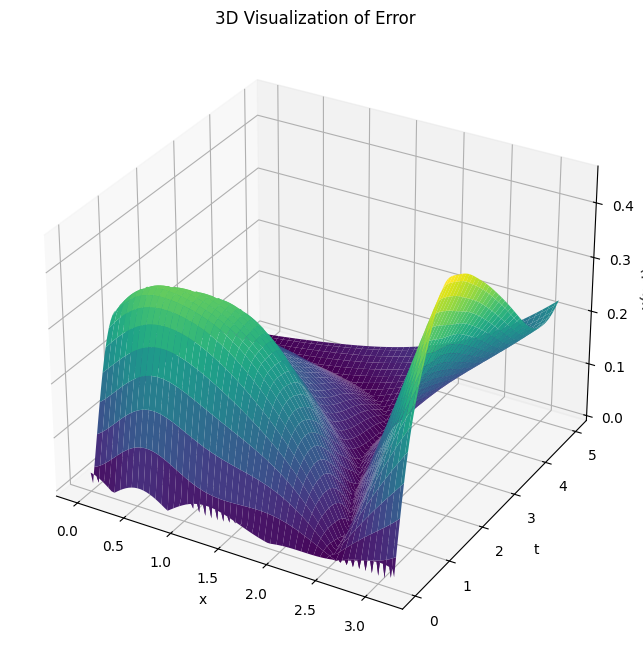

a = 0.75, b = 1.0


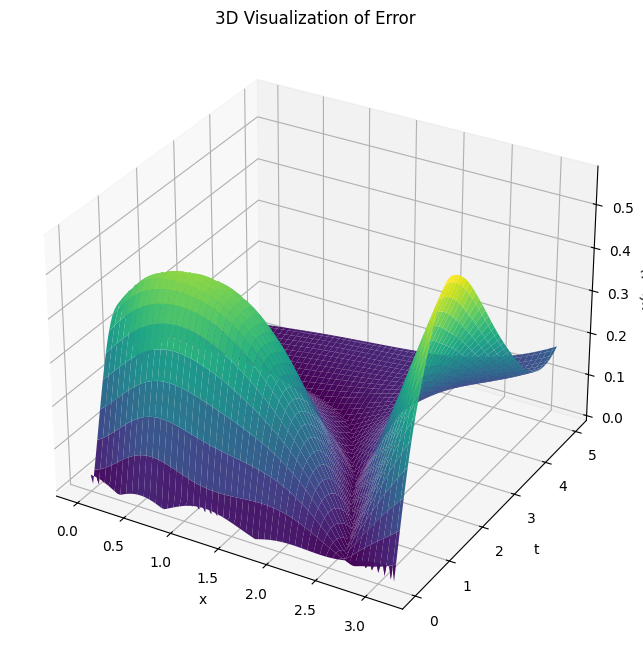

a = 1.0, b = 0.0


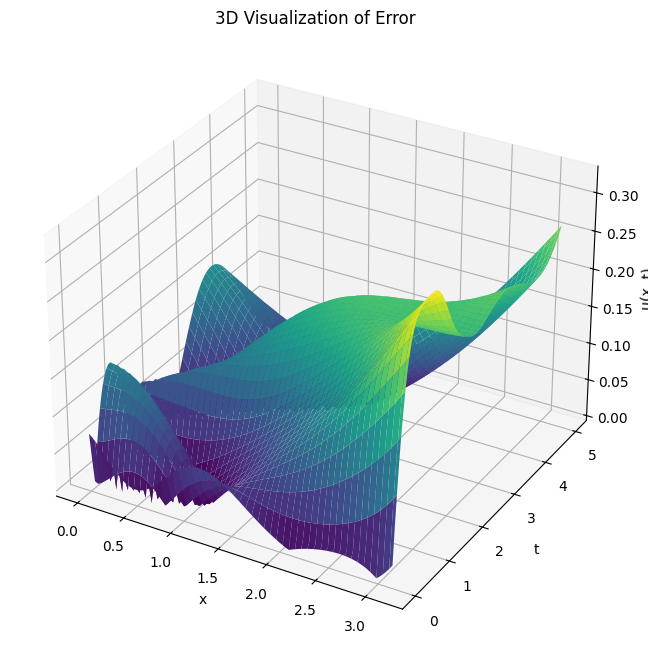

a = 1.0, b = 0.25


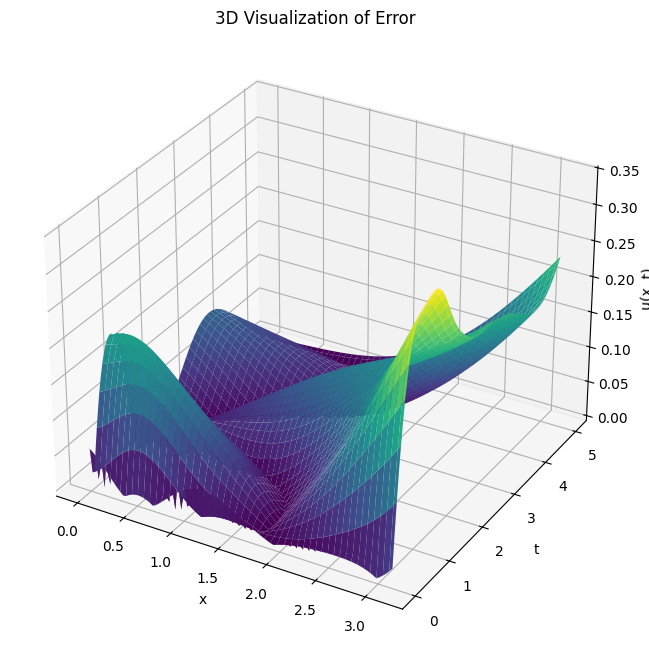

a = 1.0, b = 0.5


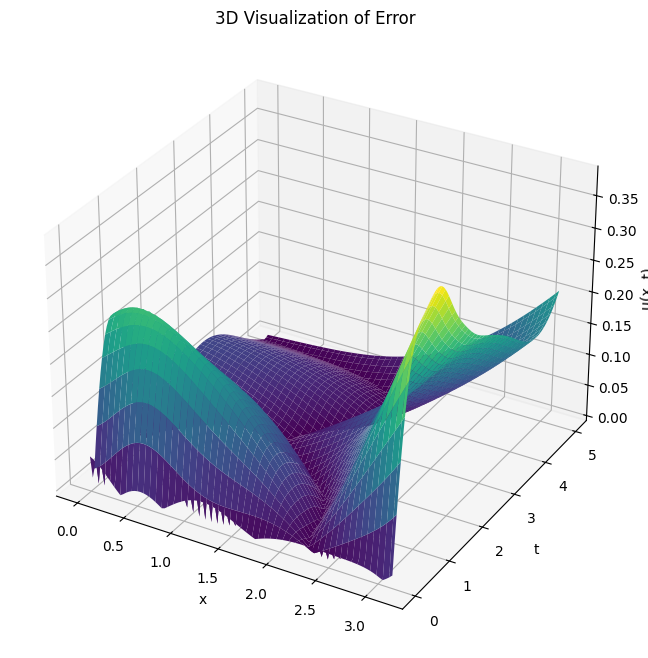

a = 1.0, b = 0.75


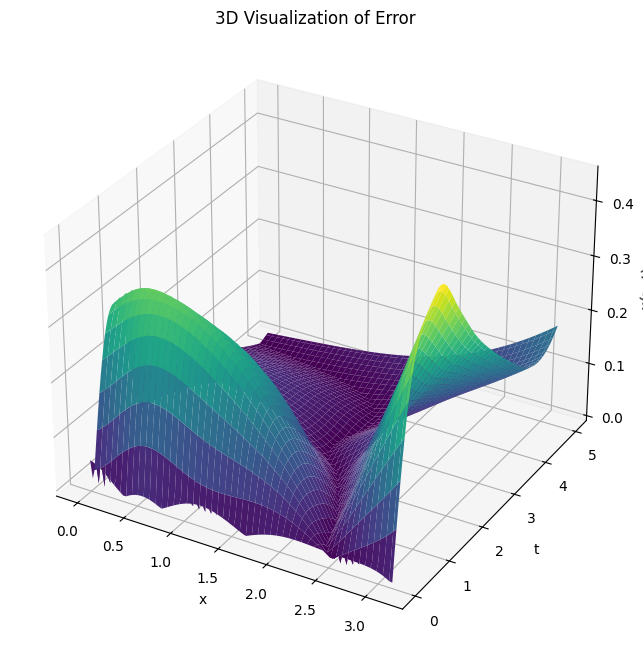

a = 1.0, b = 1.0


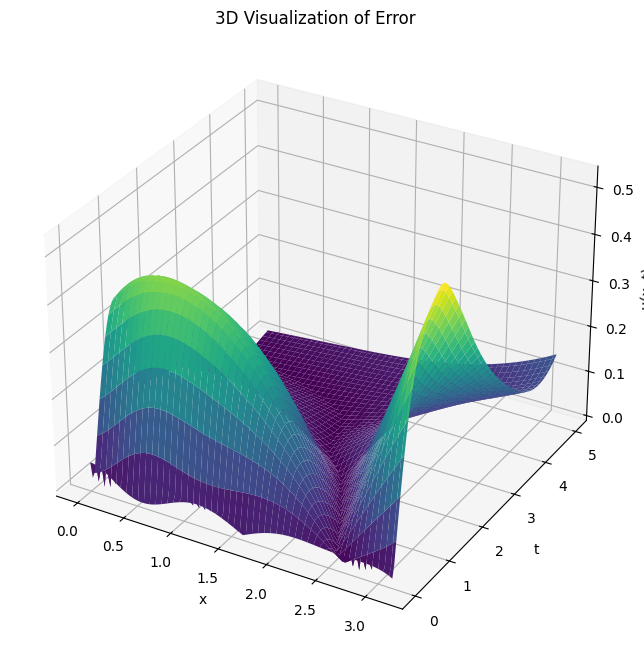

In [107]:
for a in np.linspace(0,1,5):
    for b in np.linspace(0,1,5):
        
        print(f"a = {a}, b = {b}")
        x_test = torch.tensor(np.linspace(0, np.pi, 100), dtype=torch.float32).view(-1, 1)
        t_test = torch.tensor(np.linspace(0, 5, 100), dtype=torch.float32).view(-1, 1)
        x_mesh, t_mesh = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="ij")

        a_test = torch.tensor(a, dtype=torch.float32).view(1, 1)
        b_test = torch.tensor(b, dtype=torch.float32).view(1, 1)


        u_pred = model(x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1), a_test, b_test).detach().numpy().reshape(x_mesh.shape)
        u_exact = exact_solution(x_mesh.numpy(), t_mesh.numpy(), a_test.item(), b_test.item())

        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x_mesh.numpy(), t_mesh.numpy(), np.abs(u_exact - u_pred), cmap="viridis")
        ax.set_title("3D Visualization of Error ")
        ax.set_xlabel("x")
        ax.set_ylabel("t")
        ax.set_zlabel("u(x, t)")
        plt.show()

Сейчас попробуем применить метод адаптивного изменения параметров 

In [108]:
# Инициализация обучаемых параметров a и b
a = torch.tensor(1.0, requires_grad=True, dtype=torch.float32)
b = torch.tensor(1.0, requires_grad=True, dtype=torch.float32)

In [109]:
optimizer = torch.optim.Adam([{'params': model.parameters()}, {'params': [a, b]}], lr=0.001)

In [110]:
model_adaptiv = PINN()

In [111]:
n_epochs = 10000
loss_history = []

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # Вычисляем потери для текущих значений a и b
    loss = loss_function(model_adaptiv, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation="heat")
    
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    
    if epoch % 1000 == 0:  
        print(f"Epoch {epoch}, a = {a.item()}, b = {b.item()}, Loss = {loss.item()}")

  0%|          | 26/10000 [00:00<01:17, 129.25it/s]

Epoch 0, a = 1.0010000467300415, b = 0.9990000128746033, Loss = 0.8254920840263367


 10%|█         | 1020/10000 [00:06<00:51, 175.16it/s]

Epoch 1000, a = 0.962338924407959, b = -0.24460074305534363, Loss = 0.6734087467193604


 20%|██        | 2026/10000 [00:12<00:49, 161.22it/s]

Epoch 2000, a = 0.6941516399383545, b = -0.3453845679759979, Loss = 0.6566131711006165


 30%|███       | 3022/10000 [00:18<00:44, 155.16it/s]

Epoch 3000, a = 0.6928930878639221, b = -0.3447793126106262, Loss = 0.6566129326820374


 40%|████      | 4024/10000 [00:24<00:33, 177.07it/s]

Epoch 4000, a = 0.6928920149803162, b = -0.34477880597114563, Loss = 0.6566129326820374


 50%|█████     | 5020/10000 [00:30<00:31, 156.98it/s]

Epoch 5000, a = 0.6928913593292236, b = -0.34477847814559937, Loss = 0.6566129922866821


 60%|██████    | 6024/10000 [00:36<00:25, 156.09it/s]

Epoch 6000, a = 0.692891001701355, b = -0.34477829933166504, Loss = 0.6566129922866821


 70%|███████   | 7028/10000 [00:43<00:16, 178.06it/s]

Epoch 7000, a = 0.6928907632827759, b = -0.3447782099246979, Loss = 0.6566129922866821


 80%|████████  | 8020/10000 [00:48<00:11, 178.96it/s]

Epoch 8000, a = 0.6928905844688416, b = -0.3447781503200531, Loss = 0.6566129922866821


 90%|█████████ | 9019/10000 [00:54<00:05, 179.19it/s]

Epoch 9000, a = 0.6928905844688416, b = -0.3447781205177307, Loss = 0.6566129922866821


100%|██████████| 10000/10000 [01:00<00:00, 166.04it/s]


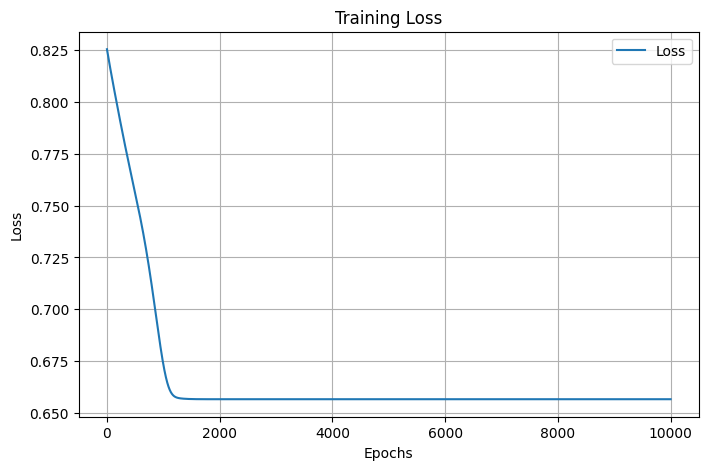

In [112]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

### Посмотрим теперь с добавлением регуляризации

In [152]:
a_min, a_max = 0.1, 2
b_min, b_max = 0.1, 2

# Параметры обучаемые, но ограничиваем их диапазон через сигмоиду
a_raw = torch.tensor(1.0, requires_grad=True, dtype=torch.float32)  # Обучаемый параметр
b_raw = torch.tensor(1.0, requires_grad=True, dtype=torch.float32)  # Обучаемый параметр

def get_constrained_params(a_raw, b_raw):
    a = torch.sigmoid(a_raw) * (a_max - a_min) + a_min
    b = torch.sigmoid(b_raw) * (b_max - b_min) + b_min
    return a, b


In [153]:
# Штраф за отклонение параметров от ожидаемого диапазона
def parameter_penalty(a, b, target_min=0.1, target_max=2):
    penalty_a = torch.clamp(a - target_max, min=0)**2 + torch.clamp(target_min - a, min=0)**2
    penalty_b = torch.clamp(b - target_max, min=0)**2 + torch.clamp(target_min - b, min=0)**2
    return penalty_a + penalty_b

def loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation="heat"):
    # Потери на внутренних точках
    u_pred = model(x_interior, t_interior, a, b)
    u_t = torch.autograd.grad(u_pred, t_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    if equation == "heat":
        physics_loss = u_t - a * u_xx
    elif equation == "wave":
        u_tt = torch.autograd.grad(u_t, t_interior, grad_outputs=torch.ones_like(u_t), create_graph=True)[0]
        physics_loss = u_tt - a * u_xx - b * u_t
    else:
        raise ValueError(f"Unknown equation type: {equation}")

    b_loss = boundary_loss(model, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b)
    param_penalty = parameter_penalty(a, b)
    return torch.mean(physics_loss**2) + b_loss + param_penalty

In [154]:
model = PINN()
optimizer = torch.optim.AdamW([{'params': model.parameters()}, {'params': [a_raw, b_raw]}], lr=0.0001)
loss_history = []

In [155]:
# Цикл обучения
n_epochs = 10000
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # Получаем ограниченные параметры
    a, b = get_constrained_params(a_raw, b_raw)

    # Вычисляем потери
    loss = loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation="heat")
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # Выводим текущие значения a и b для отслеживания изменений
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, a = {a.item()}, b = {b.item()}, Loss = {loss.item()}")

  0%|          | 25/10000 [00:00<01:22, 120.65it/s]

Epoch 0, a = 1.489011287689209, b = 1.489011287689209, Loss = 0.744653046131134


 10%|█         | 1022/10000 [00:07<00:58, 154.03it/s]

Epoch 1000, a = 1.483296513557434, b = 1.4715341329574585, Loss = 0.0027536728885024786


 20%|██        | 2031/10000 [00:13<00:49, 160.37it/s]

Epoch 2000, a = 1.4787861108779907, b = 1.470259666442871, Loss = 0.0016504209488630295


 30%|███       | 3016/10000 [00:20<00:45, 153.58it/s]

Epoch 3000, a = 1.4722691774368286, b = 1.4700106382369995, Loss = 0.0013984194956719875


 40%|████      | 4024/10000 [00:26<00:39, 151.97it/s]

Epoch 4000, a = 1.4614042043685913, b = 1.4709618091583252, Loss = 0.0012490608496591449


 50%|█████     | 5029/10000 [00:33<00:32, 150.84it/s]

Epoch 5000, a = 1.4476932287216187, b = 1.4730277061462402, Loss = 0.0011606942862272263


 60%|██████    | 6020/10000 [00:40<00:25, 153.45it/s]

Epoch 6000, a = 1.432479977607727, b = 1.4758243560791016, Loss = 0.0010856782319024205


 70%|███████   | 7028/10000 [00:46<00:19, 154.44it/s]

Epoch 7000, a = 1.415958046913147, b = 1.4789819717407227, Loss = 0.001009464031085372


 80%|████████  | 8024/10000 [00:53<00:13, 150.44it/s]

Epoch 8000, a = 1.3972647190093994, b = 1.4824930429458618, Loss = 0.0009105420904234052


 90%|█████████ | 9020/10000 [00:59<00:06, 152.63it/s]

Epoch 9000, a = 1.3759820461273193, b = 1.4867022037506104, Loss = 0.0007946798577904701


100%|██████████| 10000/10000 [01:06<00:00, 150.65it/s]


### Изменим модель

In [157]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(4, 400)  
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 200)  
        self.fc4 = nn.Linear(200, 1)  

    def forward(self, x, t, a, b):
        a = a.repeat(x.size(0), 1)
        b = b.repeat(x.size(0), 1)
        inputs = torch.cat([x, t, a, b], dim=1)
        x = torch.tanh(self.fc1(inputs))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))  
        x = self.fc4(x)
        return x

In [163]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [164]:
n_epochs = 10000
loss_history = []
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    equation_type = np.random.choice(["heat", "wave"])
    a_value = np.random.uniform(0.5, 2.0)  
    b_value = np.random.uniform(0.5, 2.0)  

    a = torch.tensor(a_value, dtype=torch.float32).view(1, 1)  
    b = torch.tensor(b_value, dtype=torch.float32).view(1, 1)  

    loss = loss_function(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, x_boundary, t_0, a, b, equation=equation_type)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

100%|██████████| 10000/10000 [02:50<00:00, 58.78it/s]


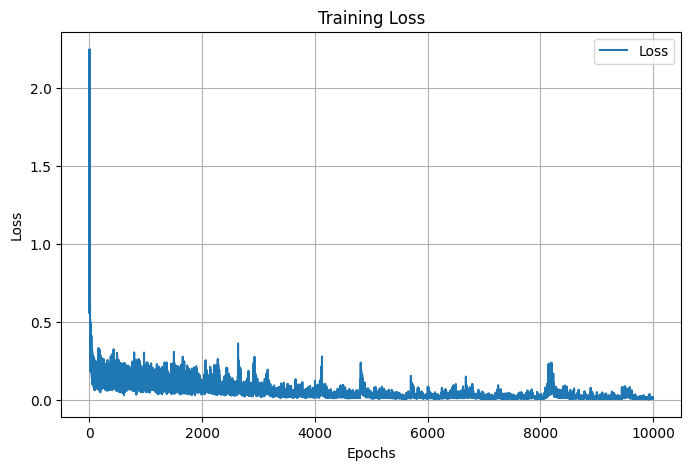

In [165]:
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

In [166]:
x_test = torch.tensor(np.linspace(0, np.pi, 100), dtype=torch.float32).view(-1, 1)
t_test = torch.tensor(np.linspace(0, 5, 100), dtype=torch.float32).view(-1, 1)
x_mesh, t_mesh = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="ij")

a_test = torch.tensor(1.0, dtype=torch.float32).view(1, 1)
b_test = torch.tensor(1.0, dtype=torch.float32).view(1, 1)


u_pred = model(x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1), a_test, b_test).detach().numpy().reshape(x_mesh.shape)
u_exact = exact_solution(x_mesh.numpy(), t_mesh.numpy(), a_test.item(), b_test.item())

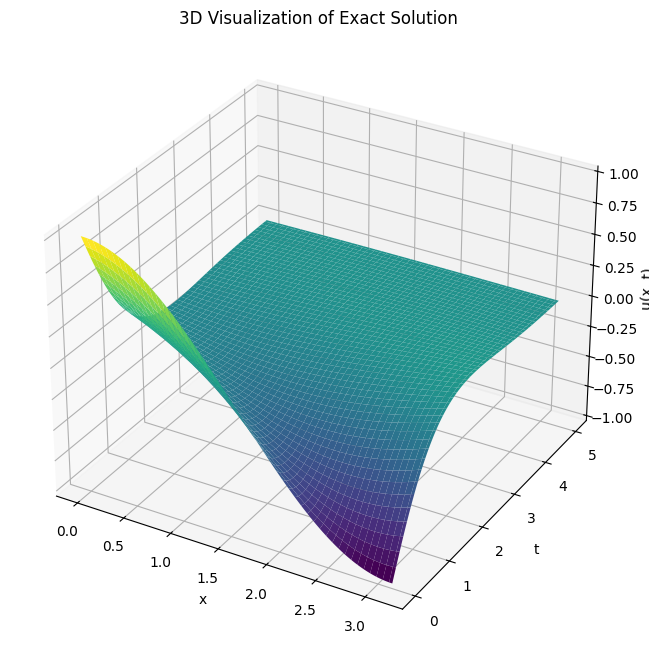

In [167]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh.numpy(), t_mesh.numpy(), u_exact, cmap="viridis")
ax.set_title("3D Visualization of Exact Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
plt.show()

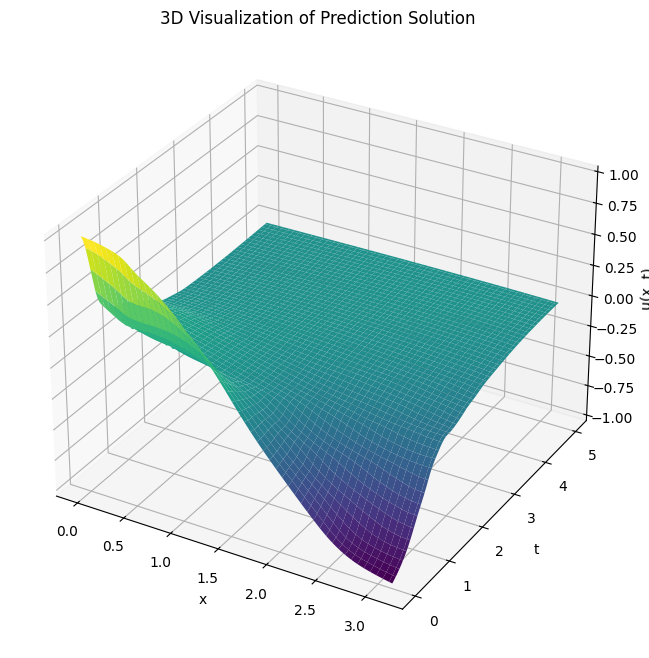

In [168]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_mesh.numpy(), t_mesh.numpy(), u_pred, cmap="viridis")
ax.set_title("3D Visualization of Prediction Solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
plt.show()